# Employment by Occupation

Making pie charts of occupation type for certain regions

Data is from:

<https://www.ons.gov.uk/datasets/TS060/editions/2021/versions/1>

from page 

<https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/employmentandemployeetypes/bulletins/industryandoccupationenglandandwales/census2021>

Here, enter the location by `Lower Tier Local Authorities` name.

In [340]:
import matplotlib.pyplot as plt
import matplotlib
import pandas
import random
import numpy

CSVFILE = "TS060-2021-1.csv"

LOCATION =  "Cheltenham"
# LOCATION =  "Cambridge"
# LOCATION =  "Kingston upon Hull"
# LOCATION =  "Sheffield"
# LOCATION =  "Newham"
# LOCATION = "ALL"

Set up a list of colours we can index by occupation type, so that colours stay the same across pie charts for different `LOCATION`s

In [341]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colours = list(matplotlib.colors.cnames.items())
random.seed(1285971)
random.shuffle(colours)

Read the CSV file, and re-index it on the Industry type

In [342]:
df = pandas.read_csv(CSVFILE)
df.set_index('Industry (current) (88 categories)', inplace=True)

Filter to only the local authority we want (with `LOCATION` from above)

Drop the "Does not apply" column. I expect this is "people who are not able to work (child or retired)"

Then, create two new dataframes for "Other" and "Other Other"

In [343]:
if LOCATION == "ALL":
    localdf = df.groupby(df.index).agg({"Observation": "sum", 'Industry (current) (88 categories) Code': "min"})
else:
    localdf = df[df["Lower Tier Local Authorities"] == LOCATION]

# drop DOES NOT APPLY
DNA_number = localdf["Observation"]["Does not apply"]
localdf = localdf.drop("Does not apply")

# add colours
localdf["colour"] = [colours[i][1] for i in localdf["Industry (current) (88 categories) Code"]]
localdf

# split by total
total = localdf["Observation"].sum()
THRESHOLD_1 = total * (1 / 100) # 1.00%
THRESHOLD_2 = total * (0.15 / 100) # 0.15%

other_colour = "#777777"

otherdf1 = localdf[localdf["Observation"] < THRESHOLD_1]
otherdf2 = localdf[localdf["Observation"] < THRESHOLD_2]

# make them go away
localdf = pandas.concat([localdf, otherdf1]).drop_duplicates(keep=False)
localdf.loc["Other"] = {"Observation": otherdf1["Observation"].sum(), "colour": other_colour}
otherdf1 = pandas.concat([otherdf1, otherdf2]).drop_duplicates(keep=False)
otherdf1.loc["Other"] = {"Observation": otherdf2["Observation"].sum(), "colour": other_colour}


plot!

make one pie chart for occupations, one for "Other", and one for "does not apply", to show context. The latter is scaled according to the square-root of the ratio of "Does not apply" to the rest of the data

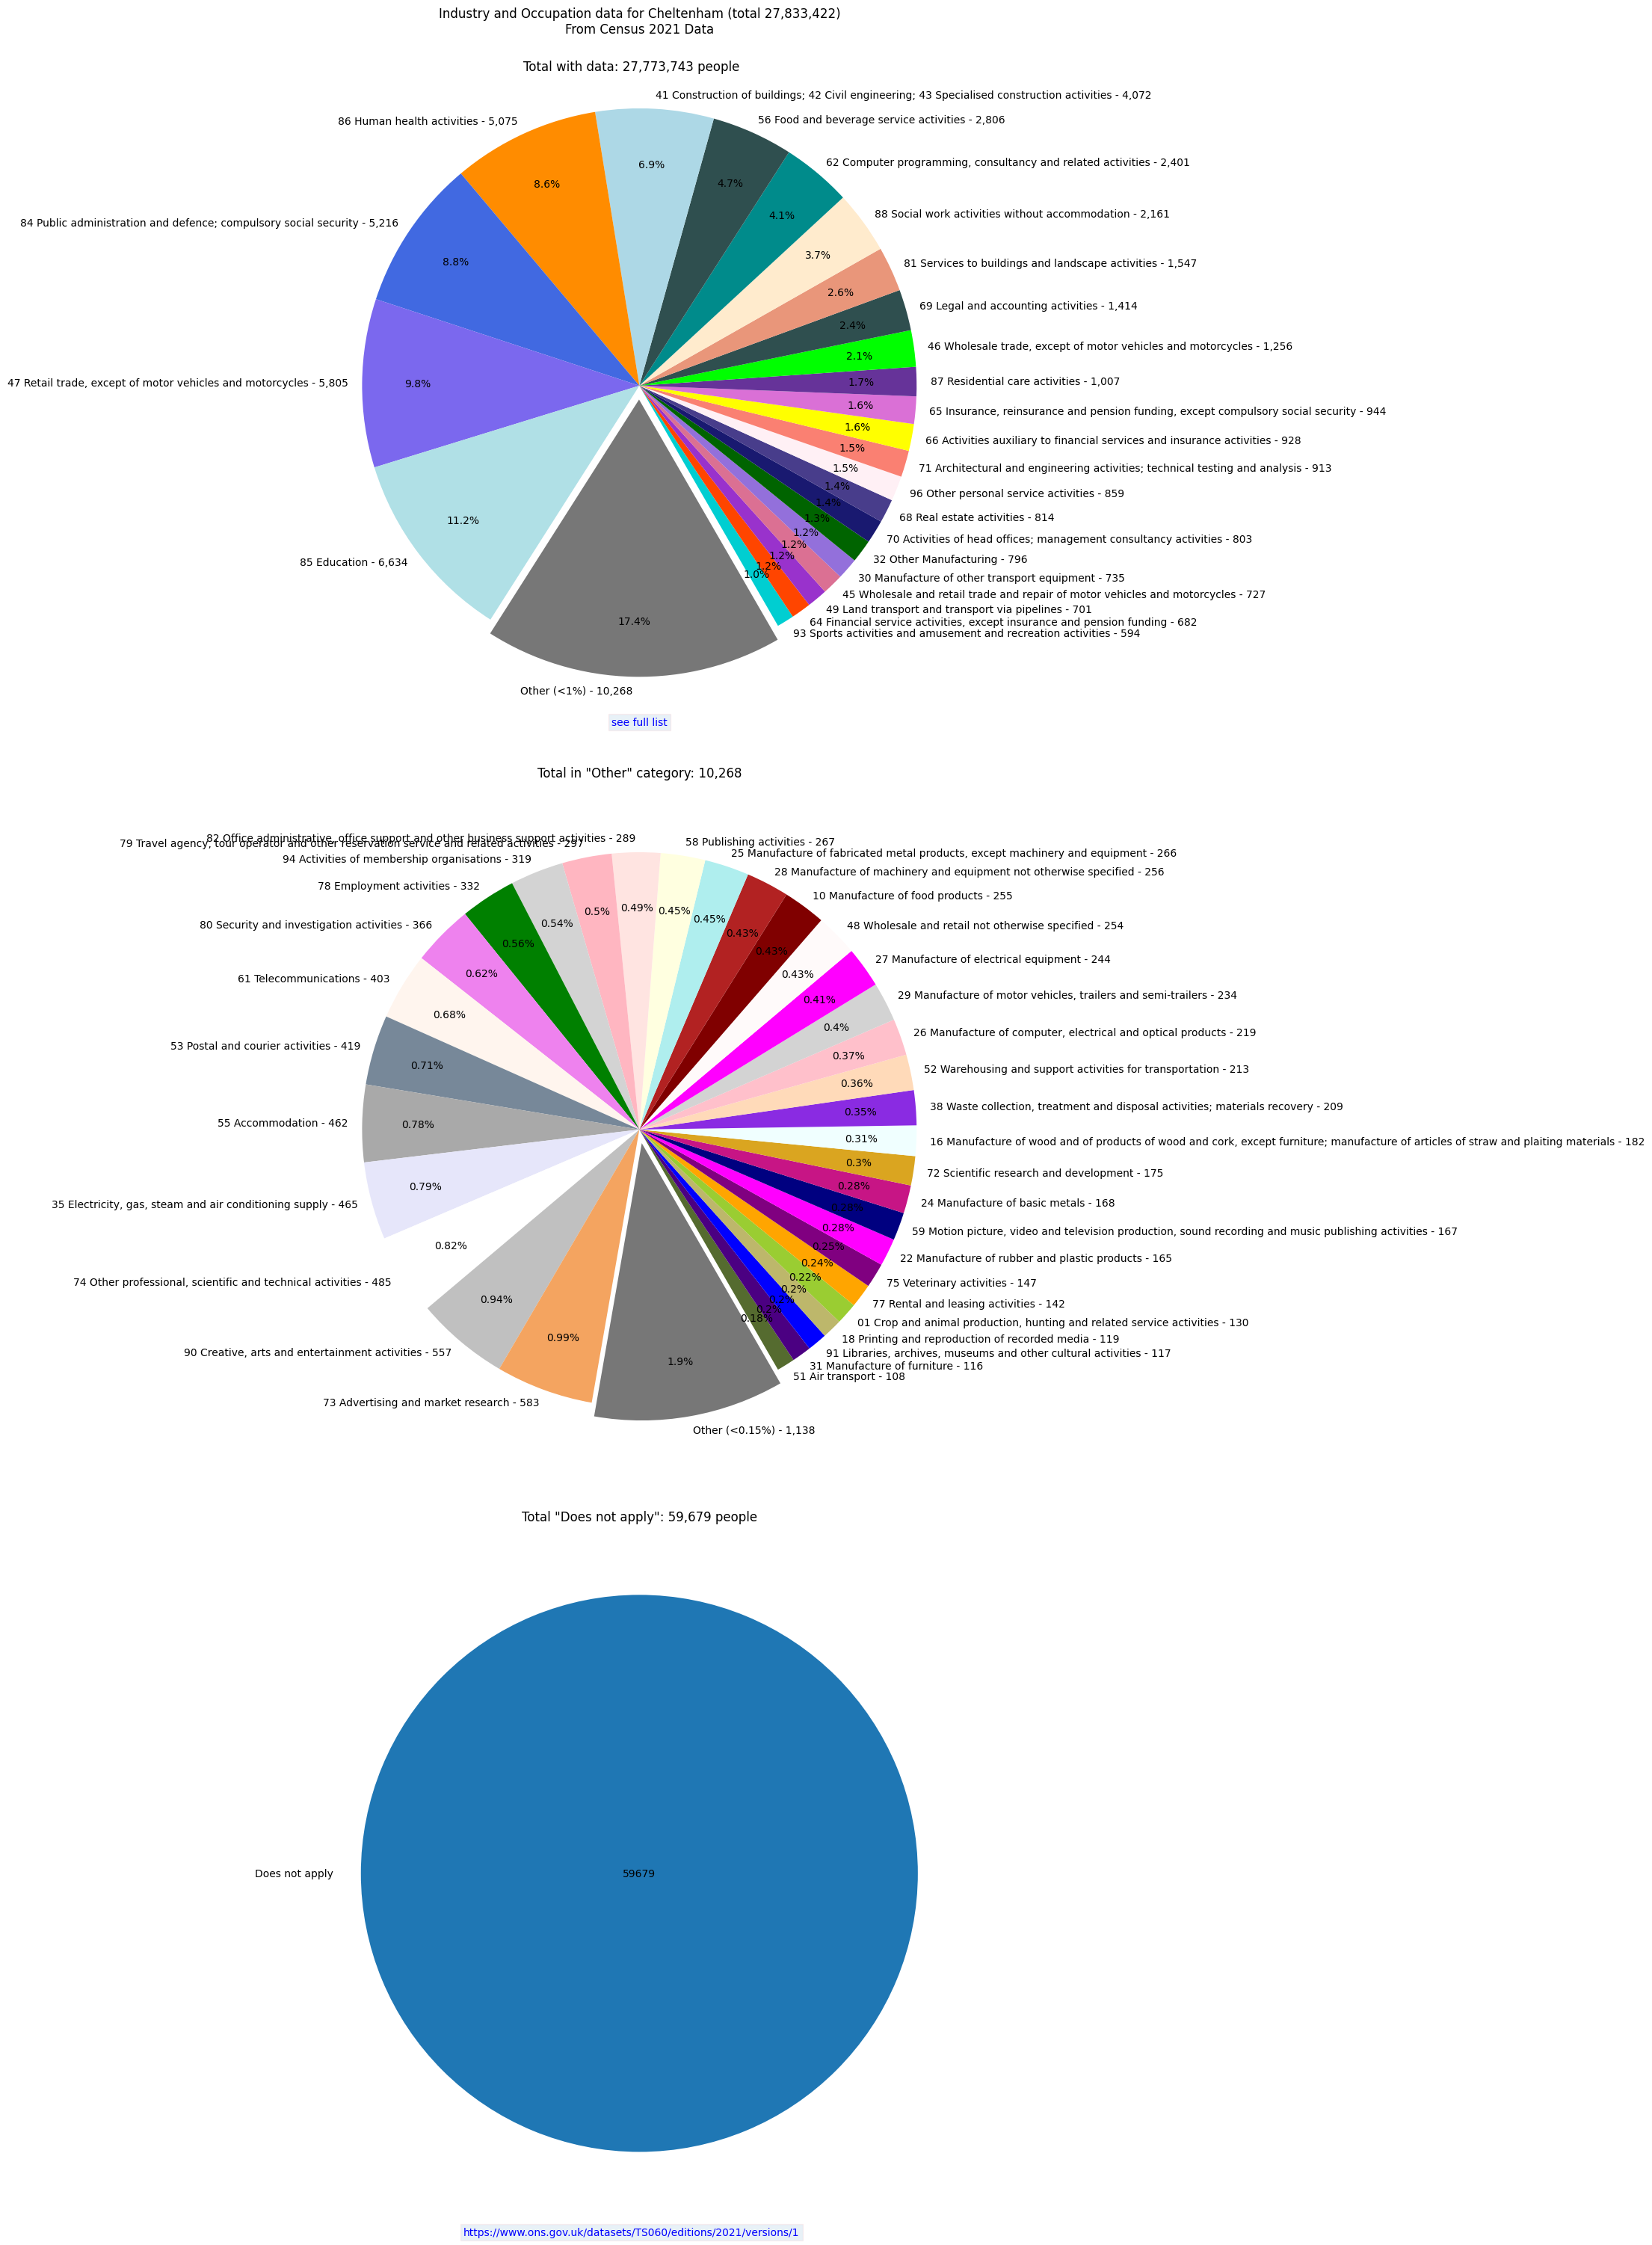

In [344]:
fig = plt.figure(figsize=(10, 30))
ax, axo1, ax2 = fig.subplots(3, 1)
fig.tight_layout()

localdf = localdf.sort_values(by="Observation")
ax.pie(
    localdf["Observation"],
    labels=[f"{ind if ind != 'Other' else 'Other (<1%)'} - {localdf['Observation'][ind]:,}" for ind in localdf.index],
    autopct='%.1f%%',
    colors=localdf["colour"],
    explode=[0.05 if b == "Other" else 0 for b in localdf.index],
    pctdistance=0.8,
    labeldistance=1.05,
    startangle=-60,
    radius=1,
)
txt = ax.text(
  0.5,
  0.01,
  "see full list",
  ha="center",
  url=f'./list.cgi?r={LOCATION}',
  color="blue",
  transform=ax.transAxes,
)
txt.set_bbox(dict(boxstyle="square", ec=(1., 0.5, 0.5),alpha=0.1,url=txt.get_url()))

otherdf1 = otherdf1.sort_values(by="Observation")
other1total = otherdf1["Observation"].sum()
axo1.pie(
    otherdf1["Observation"],
    labels=[f"{ind if ind != 'Other' else 'Other (<0.15%)'} - {otherdf1['Observation'][ind]:,}" for ind in otherdf1.index],
    autopct=lambda pct: f"{pct * other1total / total:.2}%",
    colors=otherdf1["colour"],
    explode=[0.05 if b == "Other" else 0 for b in otherdf1.index],
    pctdistance=0.8,
    labeldistance=1.05,
    startangle=-60,
    radius=1,
)

ratio = DNA_number / total
ax2.pie(
    [DNA_number],
    labels=["Does not apply"],
    radius=numpy.sqrt(ratio),
    autopct=lambda pct: DNA_number,
    pctdistance=0,
)

ax.set_title(f"Industry and Occupation data for {LOCATION} (total {DNA_number + total_applies:,})\nFrom Census 2021 Data")
ax2.set_title(f'Total \"Does not apply\": {DNA_number:,} people')
axo1.set_title(f'Total in "Other" category: {other1total:,}')
plt.suptitle(f"Total with data: {total_applies:,} people")

txt = plt.figtext(
  0.5,
  0.01,
  "https://www.ons.gov.uk/datasets/TS060/editions/2021/versions/1",
  ha="center",
  url='https://www.ons.gov.uk/datasets/TS060/editions/2021/versions/1',
  color="blue",
)
txt.set_bbox(dict(boxstyle="square", ec=(1., 0.5, 0.5),alpha=0.1,url=txt.get_url()))

plt.savefig(
    f"{LOCATION}_occupation_pie.svg",
    bbox_inches="tight",
)

plt.show()
